# CRA prediction with Regression

Reference [link](https://www.kaggle.com/apapiu/regularized-linear-models).

* Considere o pipeline mostrado nesse blog (Links para um site externo)Links para um site externo (também comentado em sala) para construir seus modelos de regressão. Isso implica, dentre outras coisas:
  * Analisar as distribuições das variáveis para ver se estão enviesadas e precisam de correção; tratamento de valores ausentes, variáveis categóricas e normalização, quando for o caso.
  * Construir modelos de regressão com (ridge e lasso) e sem regularização.
  * Considerar também modelos de regressão não paramétrica como K-NN e Kernel Regression.
  * Tunar os hiperâmetros e retornar os rmses de validação cruzada para todos os modelos avaliados
  * Plotar os resíduos versus predições e analisar se esses plots representam bons indícios da adequabilidade de modelos lineares a esse problema.
* Dois dias antes da entrega final serão liberados os dados de teste para a validação final dos modelos que você construiu.
* Para quem quiser ir além, aqui algumas ideias que podem ajudar a melhorar as predições:
  * Tente criar novas variáveis a partir das variáveis existentes, por exemplo, média de notas do período, modelos polinomiais e interações entre as variáveis.
  * Usando outros métodos de regressão. Por exemplo, SVR (Support Vector Regression), Árvores de Regressão e Florestas Aleatórias.

#### Importing packages

This packages will be used to analysis data and train the models.

In [1]:
#enconding=utf8
import copy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import skew
from scipy.stats.stats import pearsonr

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

#### Reading data

This command shows a sample from data read. We can observe that predict column is "CRA", and the other are features to train our model. The "Matricula" column shows an irrelevant feature that indicates the student identification. So, we do not consider this in training phase.

In [243]:
data = pd.read_csv("treino.csv")
data.columns = ['matricula', 'vetorial','lpt','p1','ic','lp1','calculo2','discreta','p2','grafos','fis_classica','lp2','cra','calculo1']
data.head()

,matricula,vetorial,lpt,p1,ic,lp1,calculo2,discreta,p2,grafos,fis_classica,lp2,cra,calculo1
0,0cc3d63edf0b986cb87e345972857e15,8.6,10.0,9.0,9.1,8.6,8.4,8.3,8.8,8.2,7.9,9.4,8.477647,8.7
1,0d78246db769dc958ce19fc414050b2a,5.6,7.0,7.7,7.0,8.1,6.2,7.3,8.2,5.4,7.7,8.9,6.851724,7.0
2,0f5bb983df06b90337dc2c6301fef3f6,10.0,9.8,7.9,9.6,8.3,8.7,8.8,9.5,9.2,8.6,9.7,9.090588,8.6
3,1307a4421a67a497cea198e8ccfb97ee,6.1,8.3,6.8,8.2,7.1,8.0,6.3,8.9,7.0,8.5,9.0,7.283516,7.8
4,1432d50cf8519694ab992c414d90a130,8.8,9.3,5.0,8.5,5.1,5.0,5.8,7.1,5.4,8.7,8.2,7.205747,5.2


### Distribuition analysis

#### Plot graphics

To see the distribution of predict feature (CRA), we plot the graph of distribution. We can plot to all features, but to resume data, we'll visualize only predict feature.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fad71ad3450>]], dtype=object)

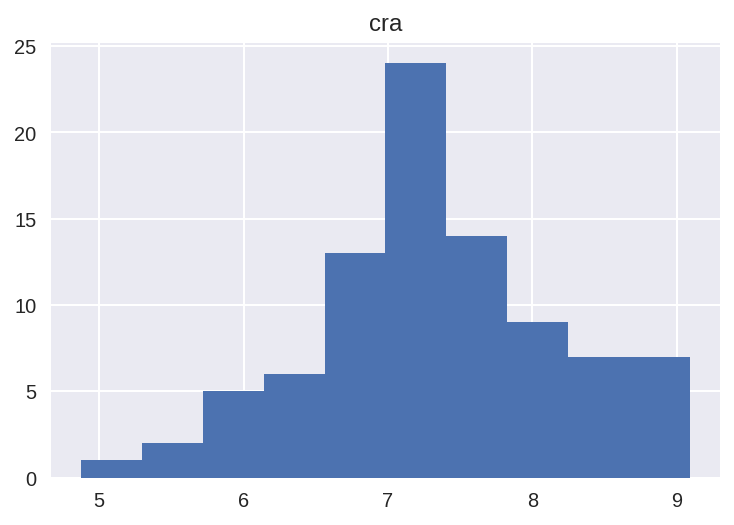

In [3]:
'''
pd.DataFrame(data.vetorial).hist()
pd.DataFrame(data.lpt).hist()
pd.DataFrame(data.p1).hist()
pd.DataFrame(data.ic).hist()
pd.DataFrame(data.lp1).hist()
pd.DataFrame(data.calculo1).hist()
pd.DataFrame(data.calculo2).hist()
pd.DataFrame(data.discreta).hist()
pd.DataFrame(data.p2).hist()
pd.DataFrame(data.grafos).hist()
pd.DataFrame(data.fis_classica).hist()
pd.DataFrame(data.lp2).hist()
'''
pd.DataFrame(data.cra).hist()

### Check skew in data

#### Skewness analysis

Let's check the skewness of data if a feature has skewness bigger than 0.75 or less than -0.75, it indicates that the feature distribution has skewness. In this case, only "LP2" feature has a strong skewness (-1.9).

In [244]:
def check_skewness(data, thresh=0.75):
    numeric_feats = data.dtypes[data.dtypes != "object"].index
    skewed_feats = data[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
    features_index = skewed_feats[(skewed_feats < -thresh) | (skewed_feats > thresh)]
    return features_index

In [245]:
features_index = check_skewness(data)

print(features_index)

lp2   -1.905429
dtype: float64


It was observed that LP2 discipline has skew, so to treat this bias, it was used exponent function.

In the graphic below, we can observe that multiplies points in the board are very distant from red line. Data without skewness will appear close to red line.

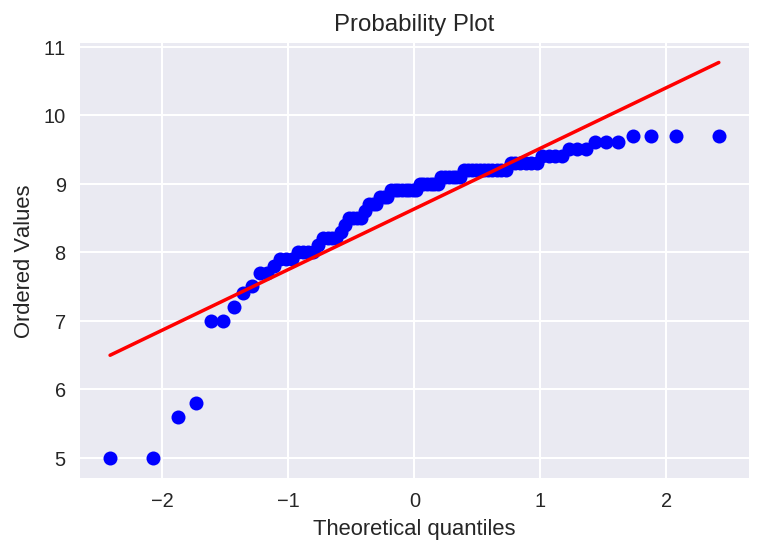

In [246]:
from scipy import stats
import matplotlib.pyplot as plt

index = features_index.index[0]
lp2 = data[index]
res = stats.probplot(lp2, plot=plt)

#### Treating "LP2" skew:

In [247]:
#exp transform skewed numeric features:
data[features_index.index] = np.exp(data[features_index.index]) # ".index" get the column name

features_index = check_skewness(data)

print(features_index)

Series([], dtype: float64)


After applying exponential function in this feature, it was removed the skewness of -1.9.

After applying exponential function in this feature, the data closer to the red line.

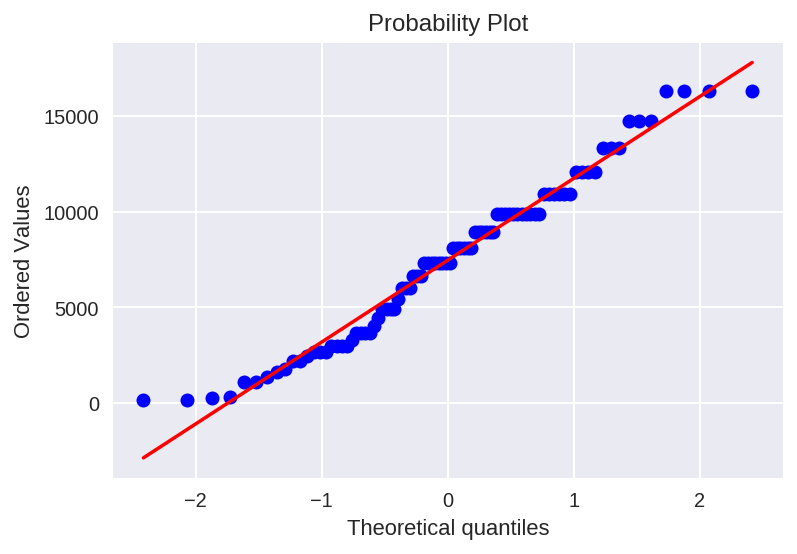

In [248]:
lp2 = data[index]
res = stats.probplot(lp2, plot=plt)

### Is necessary fill missing values?

In [221]:
data.isnull().apply(pd.value_counts)

,matricula,vetorial,lpt,p1,ic,lp1,calculo2,discreta,p2,grafos,fis_classica,lp2,cra,calculo1
False,88,88,88,88,88,88,88,88,88,88,88,88,88,88


No. How can be observed, all features have 88 values, or none line is the missing value because all matrix has 88 lines.

  # Preprocessing data

In [222]:
H = data.drop(['matricula', 'cra'], 1)
y = data['cra']

## RIDGE Regression

In [271]:
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model, X_train, y, cv_num):
    rmse = np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = cv_num))
    return(rmse)

#### Training Ridge Regression with different lambda

In [272]:
alphas = [0.0, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 40, 50, 60, 70, 80]
cv_num = 5
cv_ridge = [rmse_cv(Ridge(alpha = alpha), H, y, cv_num)
            for alpha in alphas]

#### Ploting RMSE in Ridge Regression

##### Ploting graphic

In [203]:
def plot_graphic(X, index, title, xlabel, ylabel, label):
    cv_ridge = pd.Series(X, index = index)
    cv_ridge.plot(title = title, label = label)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

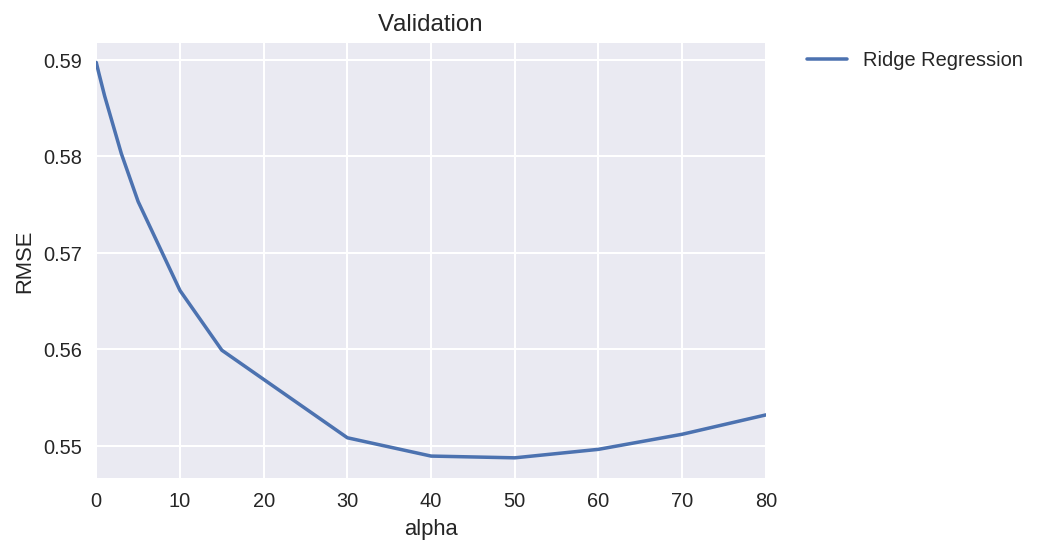

In [215]:
cv_ridge_mean = np.mean(cv_ridge, axis=1)
title = "Validation"
xlabel = "alpha"
ylabel = "RMSE"
label = "Ridge Regression"
plot_graphic(cv_ridge_mean, alphas, title, xlabel, ylabel, label)

In [273]:
small_pos = np.argmin(cv_ridge_mean) # small position
small_lambda = alphas[small_pos]

In this graphic, we can observe the Root Mean Square Error for different lambdas. The smallest error is desirable, in this case, when lambda = 50. And, without regularization (lambda=0), the results were worst in interval [0:80].

#### Plotting error in cross with smallest RMSE

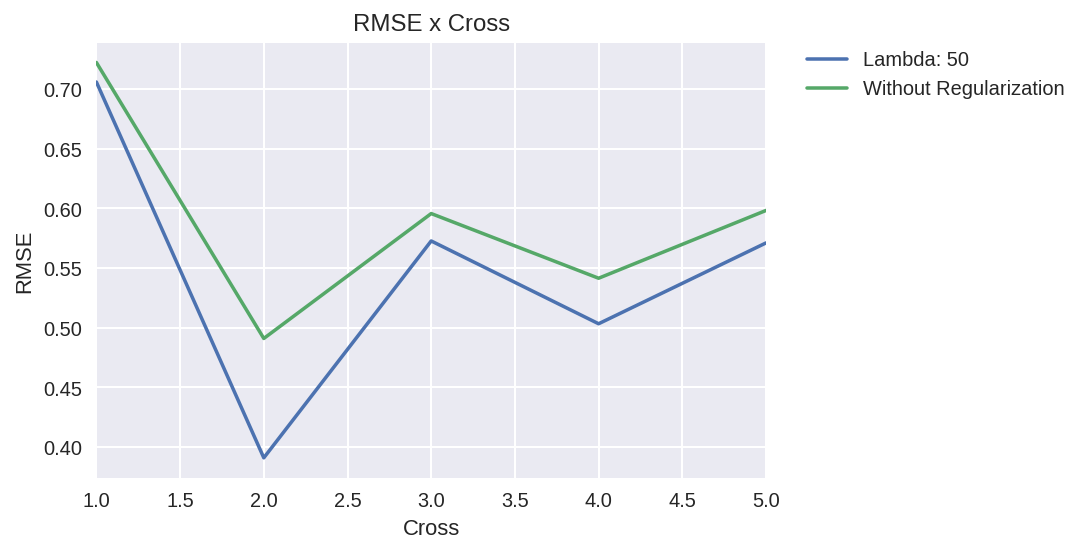

In [274]:
seq = np.arange(1, cv_num+1) # 1, ..., cv_num
small_rmse_ridge = cv_ridge[small_pos]
plot_graphic(small_rmse_ridge, seq, "RMSE x Cross", "Cross", "RMSE", "Lambda: {0}".format(small_lambda))
plot_graphic(cv_ridge[0], seq, "RMSE x Cross", "Cross", "RMSE", "Without Regularization") #Without Regularization

In this graphic, we can observe the RMSE to each cross using lambda=50 (smallest RMSE) and without regularization (bigger RMSE in the interval [0-80]).

#### Training a model with all data 

In [282]:
ols = Ridge(alpha=0.0)
ridge_adjusted = Ridge(alpha=small_lambda)

ols.fit(H, y)
ridge_adjusted.fit(H, y)

from numpy import linalg as LA
print("Norma OLS: {0}".format(LA.norm(ols.coef_)))
print("Norma Ridge (lambda={0}): {1}".format(small_lambda, LA.norm(ridge_adjusted.coef_)))

Norma OLS: 0.367397692096
Norma Ridge (lambda=50): 0.268388764367


## LASSO Regression

## KNN

## Kernel 

## Turn hyperparams with cross-validation

## Residual versus Prediction